Epoch 1/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 270ms/step - loss: 0.1068 - val_loss: 0.0735
Epoch 2/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0653 - val_loss: 0.0516
Epoch 3/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 33ms/step - loss: 0.0410 - val_loss: 0.0408
Epoch 4/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0331 - val_loss: 0.0379
Epoch 5/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step - loss: 0.0381 - val_loss: 0.0382
Epoch 6/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step - loss: 0.0366 - val_loss: 0.0375
Epoch 7/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0368 - val_loss: 0.0355
Epoch 8/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step - loss: 0.0347 - val_loss: 0.0331
Epoch 9/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step - loss: 0.0320 - val_loss: 0.0312
Epoch 10/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step - loss: 0.0279 - val_loss: 0.0300
Epoch 11/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0285 - val_loss: 0.0293
Epoch 12/75
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 32ms/step - loss: 0.0267 - val_loss: 0.0286


Dropdown(description='Opponent:', options=('Army', 'Bucknell', 'Lehigh', 'Boston University', 'Navy', 'Lafayet…

Dropdown(description='Location:', options=('Away', 'Home'), value='Away')

Button(description='Predict Score', style=ButtonStyle())

Output()

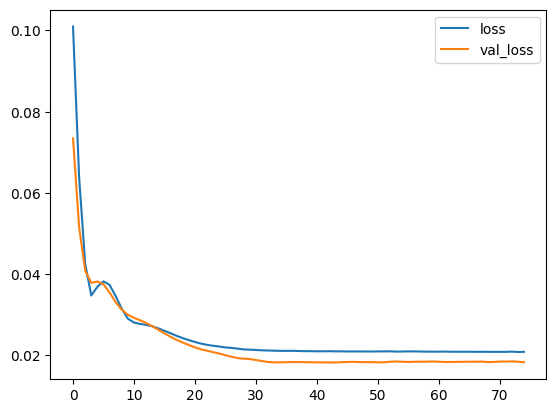

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import preprocessing
import keras 
import tensorflow as tf 
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
import ipywidgets as widgets
from IPython.display import display, clear_output
import warnings
warnings.filterwarnings("ignore")

data = pd.read_csv('data.csv')
data.head()

from sklearn.preprocessing import LabelEncoder

df = data.drop(['win'], axis=1)

X = df.drop(['colgateScore', 'oppScore'], axis=1)
y = df[['colgateScore', 'oppScore']]

opponent_encoder = preprocessing.LabelEncoder()
location_encoder = preprocessing.LabelEncoder()

X['opponent'] = opponent_encoder.fit_transform(X['opponent'])
X['location'] = location_encoder.fit_transform(X['location'])

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

X_scaler = MinMaxScaler()
X_train_scaled = X_scaler.fit_transform(X_train)
X_test_scaled = X_scaler.transform(X_test)

# Target Scaling (to prevent extreme scores)
y_scaler = MinMaxScaler()
y_train_scaled = y_scaler.fit_transform(y_train)
y_test_scaled = y_scaler.transform(y_test)

model = keras.Sequential([
    keras.layers.Input(shape=(X_train_scaled.shape[1],)),
    keras.layers.Dense(256, activation='relu'),
    keras.layers.Dense(128, activation='relu'),
    keras.layers.Dense(2, activation='linear')
])

huber_loss = tf.keras.losses.Huber(delta=1.0)
model.compile(optimizer='adam', loss=huber_loss)

model.fit(X_train_scaled, y_train_scaled, epochs=75, batch_size=64, validation_data=(X_test_scaled, y_test_scaled))

model_losses = pd.DataFrame(model.history.history)
model_losses.plot()

opponent = widgets.Dropdown(options=df['opponent'].unique().tolist(), description='Opponent:')
location = widgets.Dropdown(options=df['location'].unique().tolist(), description='Location:')
predict_button = widgets.Button(description="Predict Score")
output = widgets.Output()

def predict_score(b):
    with output:
        clear_output()

        selected_opponent = opponent.value
        selected_location = location.value

        try:
            encoded_opponent = opponent_encoder.transform([selected_opponent])
        except ValueError:
            encoded_opponent = -1
        
        try:
            encoded_location = location_encoder.transform([selected_location])
        except ValueError:
            encoded_location = -1

        input_data = np.array([[encoded_opponent[0], encoded_location[0]]])
        input_data_scaled = X_scaler.transform(input_data)

        predicted_scores_scaled = model.predict(input_data_scaled)

        predicted_scores = y_scaler.inverse_transform(predicted_scores_scaled)

        predicted_colgate_score = int(round(predicted_scores[0, 0]))
        predicted_opp_score = int(round(predicted_scores[0, 1]))

        print(f"Predicted Colgate Score: {predicted_colgate_score}")
        print(f"Predicted Opponent Score: {predicted_opp_score}")

        if predicted_colgate_score > predicted_opp_score:
            print("Colgate is predicted to WIN!")
        elif predicted_colgate_score < predicted_opp_score:
            print("Colgate is predicted to LOSE!")
        else:
            print("It's a DRAW!")


predict_button.on_click(predict_score)

display(opponent, location, predict_button, output)